In [1]:
import pandas as pd
import numpy as np


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, AdamW, get_linear_schedule_with_warmup
from torch.optim import AdamW
from tqdm import tqdm

import pickle
import EncoderModel as mm
import NNModel as nn2

In [2]:
df = pd.read_csv('filter_df.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65506 entries, 0 to 65505
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  65506 non-null  int64  
 1   법령명         65506 non-null  object 
 2   조문제목        65506 non-null  object 
 3   조문          65506 non-null  object 
 4   사무판단        65506 non-null  int64  
 5   사무유형(대분류)   65506 non-null  object 
 6   rule_based  65506 non-null  int64  
 7   사무예측 결과     65506 non-null  int64  
 8   사무예측 확률     65506 non-null  float64
dtypes: float64(1), int64(4), object(4)
memory usage: 4.5+ MB


In [3]:
df.shape

(65506, 9)

In [4]:
df.head(3)

,Unnamed: 0,법령명,조문제목,조문,사무판단,사무유형(대분류),rule_based,사무예측 결과,사무예측 확률
0,830918,환경영향평가법 시행규칙,규제의 재검토,② 환경부장관은 다음 각 호의 사항에 대하여 해당 호에 해당하는 날을 기준으로 2년...,0,0,1,1,0.70103
1,505105,장애인복지법 시행규칙,장애인자립생활지원센터의 운영기준,"자립생활센터는 조직 운영, 사업 수행, 재정 확보, 운용 등에 대해 객관적으로 평가...",0,0,1,1,0.58506
2,673376,국제항해선박 및 항만시설의 보안에 관한 법률 시행규칙,국제항해여객선 승객 등의 보안검색의 실시방법과 절차 등,③ 제1항의 항만시설소유자는 다음 각 호의 어느 하나에 해당하는 경우에 승선하는 자...,0,0,1,1,0.61962


In [5]:
# 사무유형 종류 불러오기
with open('subject_list.pkl', 'rb') as file:
    subject_list = pickle.load(file)

subject_list

['대도시',
 '2023 순천만국제정원박람회조직위원회',
 '5·18민주화운동 진상규명조사위원회',
 '계약담당자',
 '대검찰청',
 '대한민국법인',
 '가석방심사위원회',
 '가정보호사건조사관',
 '가정위탁지원센터',
 '가축방역기관장',
 '가축병성감정실시기관',
 '가축전염병피해보상협의회',
 '기관',
 '본부',
 '부대',
 '학교',
 '장관',
 '간사',
 '갈등관리심의위원회',
 '감독기관',
 '감독청',
 '감사',
 '감사관',
 '감사원',
 '감사위원회',
 '감사활동을 수행하는 사람',
 '감염병관리위원회',
 '감염병병원체 확인기관',
 '감정평가법인',
 '감항인증심의위원회',
 '개발센터',
 '개발원',
 '갱생보호회지소장',
 '거래소',
 '거주자',
 '건강보험공단',
 '건강보험분쟁조정위원회',
 '건강보험심사평가원',
 '건설기계사업자설립협회',
 '건설사업자',
 '건설엔지니어링사업자',
 '건설청',
 '건축위원회',
 '건축주',
 '건축허가관청',
 '검사',
 '검사공무원',
 '검사위원회',
 '검역기관',
 '검역본부',
 '검역소',
 '검정고시위원회',
 '검정기관',
 '검찰',
 '검찰관',
 '검찰단장',
 '검찰부',
 '검찰서기',
 '검찰인사위원회',
 '검찰청',
 '경계변경협의체',
 '경기도지사',
 '경상남도',
 '경영자',
 '경영책임자',
 '경쟁력위원회',
 '경제관계장관회의',
 '경제교육단체',
 '경제사회노동위원회',
 '경제자유구역위원회',
 '경제자유구역청',
 '경찰',
 '경찰공무원',
 '경찰관',
 '경찰관서',
 '경찰교육기관',
 '경찰기관',
 '경찰병원',
 '경찰서',
 '경찰청',
 '계약담당공무원',
 '계약상대방',
 '계엄사령관',
 '계정출납명령관',
 '고등검찰청',
 '고등학교',
 '고령사회위원회',
 '고용노동부',
 '고용보험위원회',
 '고용정책심의회',
 '고위공직자범죄수사처',
 '공공관리주체',
 '공공기관',
 '공공

In [6]:
# 수행주체 열 추가
df['수행주체'] = '0'

for i in tqdm(range(df.shape[0]), desc="Processing rows"):
    text = df.loc[i, '조문']
    actor = ''
    for subject in subject_list:
        if subject in text:
            actor += (' ' + subject)
    df.loc[i, '수행주체'] = actor

Processing rows: 100%|██████████████████| 65506/65506 [00:11<00:00, 5680.72it/s]


In [7]:
# 라벨 인코딩
df.loc[df['사무유형(대분류)']=='국가', '사무유형(대분류)'] = 1
df.loc[df['사무유형(대분류)']=='지방', '사무유형(대분류)'] = 2
df.loc[df['사무유형(대분류)']=='공동', '사무유형(대분류)'] = 3

df['사무유형(대분류)'] = df['사무유형(대분류)'].astype(int)

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit

# StratifiedShuffleSplit을 사용하여 데이터를 분리
stratified_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, val_index in stratified_splitter.split(df, df['사무유형(대분류)']):
    train_df = df.iloc[train_index]
    val_df = df.iloc[val_index]

# 모델 불러오기

In [9]:
# 모델 및 토크나이저 불러오기
model_name = 'klue/roberta-large'
tokenizer = AutoTokenizer.from_pretrained(model_name)

input_size = 128
hidden_size = 64
output_size = 4

encoder = mm.MyModel(input_size, hidden_size, output_size)
deep = nn2.MyModel(input_size, hidden_size, output_size)

In [10]:
# 데이터셋 정의
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer):
        self.data = dataframe
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # '조문'과 '법령명' 칼럼의 데이터를 안전하게 문자열로 변환하고 결합
        text1 = str(self.data.iloc[idx]['법령명'])
        text2 = str(self.data.iloc[idx]['조문제목'])
        text3 = str(self.data.iloc[idx]['수행주체'])
        text_data = text1 + " // " + text2 + " // " + text3
        label = torch.tensor(self.data.iloc[idx]['사무유형(대분류)'], dtype=torch.long)

        # 결합된 텍스트를 토크나이징
        tokenized_data = tokenizer([text_data], padding='max_length', max_length=128, truncation=True, return_tensors='pt')

        return {
            'input_ids': tokenized_data['input_ids'].squeeze(),
            'attention_mask': tokenized_data['attention_mask'].squeeze(),
            'labels': label
        }

In [11]:
# 각 배치의 텍스트 길이를 맞추기
def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]
    labels = [item['labels'] for item in batch]

    # 패딩
    input_ids = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask = torch.nn.utils.rnn.pad_sequence(attention_mask, batch_first=True, padding_value=0)

    return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': torch.stack(labels)}

In [12]:
# 데이터로더 생성
batch_size = 16  # 배치크기 조절

train_dataset = CustomDataset(train_df, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

val_dataset = CustomDataset(val_df, tokenizer)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [13]:
# 손실 기록을 위한 리스트
encoder_train_losses = []
#deep_train_losses = []

encoder_val_losses = []
#deep_val_losses = []
num_epochs = 6
total_steps = len(train_loader) * num_epochs

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [14]:
from sklearn.utils.class_weight import compute_class_weight

class_labels = [0, 1, 2, 3]  # '사무유형(대분류)' 열의 클래스 라벨
class_weights = compute_class_weight('balanced', classes=class_labels, y=train_df['사무유형(대분류)'].values)
class_weights = torch.FloatTensor(class_weights)

# 가중치 출력
print(class_weights)

tensor([ 0.2969,  2.2733,  9.0853, 12.1531])


# 인코더 학습

In [15]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def cal_result(preds, y):
    conf_matrix = confusion_matrix(y, preds)
    print('혼동행렬')
    print(conf_matrix)
    accuracy = accuracy_score(y, preds)
    print(f'정확도: {accuracy}')
    class_report = classification_report(y, preds)
    print('Classification Report:')
    print(class_report)
    
    return conf_matrix

In [16]:
# 나머지 파라미터 정리
optimizer = AdamW(encoder.parameters(), lr=1e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# 학습 루프에서 'labels'를 사용하는 부분 수정
for epoch in range(num_epochs):
    encoder.train()
    total_loss = 0.0
    for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs} - Training'):
        inputs = {key: value.to(device) for key, value in batch.items() if key != 'labels'}
        labels = batch['labels'].to(device)

        # 모델에 토큰화된 입력 데이터 전달
        logits = encoder(**inputs).float()
        loss = torch.nn.functional.cross_entropy(logits, labels, weight=class_weights)
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    encoder_train_losses.append(avg_train_loss)
    print(f'Epoch {epoch + 1}/{num_epochs}, Average Training Loss: {avg_train_loss}')

    encoder.eval()
    val_loss = 0.0
    y_true = []  # 실제 레이블을 저장할 리스트
    y_pred = []  # 모델의 예측 결과를 저장할 리스트
    y_probs = [] # 사무유형별 확률 저장할 리스트
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f'Epoch {epoch + 1}/{num_epochs} - Validation'):
            inputs = {key: value.to(device) for key, value in batch.items() if key != 'labels'}
            labels = batch['labels'].to(device)

            # 모델에 토큰화된 입력 데이터 전달
            outputs = encoder(**inputs).float()
            
            # 마지막 epoch에서의 확률값 저장
            if (epoch + 1) == num_epochs:
                probs = torch.nn.functional.softmax(outputs, dim=1)
                y_probs.extend(probs.cpu().numpy())
            
            _, predictions = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())
            val_loss += torch.nn.functional.cross_entropy(outputs, labels, weight=class_weights)

    avg_val_loss = val_loss / len(val_loader)
    encoder_val_losses.append(avg_val_loss)
    print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {avg_val_loss}')

Epoch 1/6 - Training: 100%|████████████████| 3276/3276 [00:18<00:00, 176.50it/s]


Epoch 1/6, Average Training Loss: 1.4135651366105155


Epoch 1/6 - Validation: 100%|████████████████| 819/819 [00:02<00:00, 280.36it/s]


Epoch 1/6, Validation Loss: 1.363835096359253


Epoch 2/6 - Training: 100%|████████████████| 3276/3276 [00:18<00:00, 177.93it/s]


Epoch 2/6, Average Training Loss: 1.3393549661314677


Epoch 2/6 - Validation: 100%|████████████████| 819/819 [00:02<00:00, 289.24it/s]


Epoch 2/6, Validation Loss: 1.3229365348815918


Epoch 3/6 - Training: 100%|████████████████| 3276/3276 [00:19<00:00, 167.35it/s]


Epoch 3/6, Average Training Loss: 1.3145729713278376


Epoch 3/6 - Validation: 100%|████████████████| 819/819 [00:03<00:00, 255.99it/s]


Epoch 3/6, Validation Loss: 1.3070497512817383


Epoch 4/6 - Training: 100%|████████████████| 3276/3276 [00:20<00:00, 158.40it/s]


Epoch 4/6, Average Training Loss: 1.3056674365486418


Epoch 4/6 - Validation: 100%|████████████████| 819/819 [00:03<00:00, 259.58it/s]


Epoch 4/6, Validation Loss: 1.3010615110397339


Epoch 5/6 - Training: 100%|████████████████| 3276/3276 [00:20<00:00, 159.51it/s]


Epoch 5/6, Average Training Loss: 1.298574465498674


Epoch 5/6 - Validation: 100%|████████████████| 819/819 [00:03<00:00, 258.48it/s]


Epoch 5/6, Validation Loss: 1.301025390625


Epoch 6/6 - Training: 100%|████████████████| 3276/3276 [00:20<00:00, 159.19it/s]


Epoch 6/6, Average Training Loss: 1.295411134322921


Epoch 6/6 - Validation: 100%|████████████████| 819/819 [00:02<00:00, 273.04it/s]

Epoch 6/6, Validation Loss: 1.2972936630249023


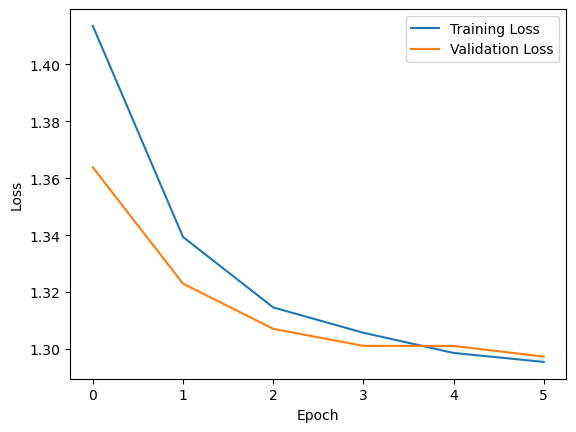

In [17]:
import matplotlib.pyplot as plt

# 손실 값 시각화
plt.plot(encoder_train_losses, label='Training Loss')
plt.plot(encoder_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
# 피클 파일 생성
torch.save(encoder.state_dict(), 'type4/encoder_model2_type4.pth')    

In [19]:
probs = pd.DataFrame(y_probs)

In [20]:
encoder_result = pd.DataFrame({
    'Label': y_true,
    'Pred': y_pred,
    '비사무 확률': round(probs[0], 5),
    '국가 확률': round(probs[1], 5),
    '지방 확률': round(probs[2], 5),
    '공동 확률': round(probs[3], 5)
})

encoder_result

,Label,Pred,비사무 확률,국가 확률,지방 확률,공동 확률
0,0,0,0.60170,0.20750,0.07296,0.11783
1,1,0,0.46655,0.33899,0.09310,0.10136
2,0,0,0.32144,0.31703,0.19759,0.16394
3,0,0,0.51072,0.25230,0.09998,0.13701
4,0,0,0.43375,0.35314,0.08525,0.12786
...,...,...,...,...,...,...
13097,1,0,0.46681,0.22467,0.15761,0.15091
13098,0,0,0.35817,0.34251,0.13017,0.16915
13099,0,0,0.36710,0.24127,0.16672,0.22492
13100,0,0,0.46054,0.17710,0.15262,0.20973


In [ ]:
cal_result(encoder_result['Pred'], encoder_result['Label'])

In [ ]:
encoder_result

In [ ]:
# 행별 최대값 - 두번째 최대값 차이 계싼 함수
def get_diff(df):
    df['차이'] = 0
    for i in range(len(df)):
        s_row = sorted(list(df.iloc[i, 2:6]), reverse=True)
        df.loc[i, '차이'] = s_row[0] - s_row[1]
    
    return df

# 학실 주의 구분 함수
def need_to_check_plus(threshold, df):
    df['need_to_check'] = 0
    df.loc[df['차이'] < threshold, 'need_to_check'] = 1
    return df

# 학실, 주의별 확인 함수
def check_result(result):
    jF = result.loc[(result['need_to_check']==1)&(result['Label']!=result['Pred']), :]
    jT = result.loc[(result['need_to_check']==1)&(result['Label']==result['Pred']), :]
    hF = result.loc[(result['need_to_check']==0)&(result['Label']!=result['Pred']), :]
    hT = result.loc[(result['need_to_check']==0)&(result['Label']==result['Pred']), :]
    
    print(f'주의 사무 개수: {len(jF) + len(jT)}')
    print(f'주의에서 틀린 개수: {len(jF)}')
    print(f'주의에서 맞은 개수: {len(jT)}')
    print('------------------')
    print(f'확실 사무 개수: {len(hF) + len(hT)}')
    print(f'확실에서 틀린 개수: {len(hF)}')
    print(f'확실에서 맞은 개수: {len(hT)}')
    
    h_ratio = len(hT)/(len(hF)+len(hT))
    j_ratio = len(jT)/(len(jF)+len(jT))
    
    return h_ratio, j_ratio  # 확실 사무중 맞은 것의 개수

In [ ]:
result1 = get_diff(encoder_result)
thresholds = np.arange(0.1, 0.5, 0.05)

for t in thresholds:
    print(f'임계값: {t}')
    print("*************")
    ex = need_to_check_plus(t, result1)
    h_ratio, j_ratio = check_result(ex)
    print("============")
    print(f"확실 정확도: {h_ratio}")
    print(f"애매 정확도: {j_ratio}")
    print("*************")
    print()

In [ ]:
result1 = need_to_check_plus(0.3, result1)   # 임계값 0.3 에서 확실정확도 94%

In [ ]:
cal_result(result1.loc[result1['need_to_check']==0, 'Pred'], result1.loc[result1['need_to_check']==0,'Label'])

In [ ]:
cal_result(result1.loc[result1['need_to_check']==1, 'Pred'], result1.loc[result1['need_to_check']==1,'Label'])

In [ ]:
result1

# 두번째 상위 확률까지 고려했을때 결과 확인

In [ ]:
result1['second_pred'] = result1.loc[:,'비사무 확률':'공동 확률'].apply(lambda row: row.nlargest(2).index[1], axis=1)

cols = ['비사무 확률', '국가 확률', '지방 확률', '공동 확률']
for i in range(len(cols)):
    result1.loc[result1['second_pred']==cols[i], 'second_pred'] = i

In [ ]:
result1['second_pred'] = result1['second_pred'].astype(int)

In [ ]:
result1['second_chance'] = result1['Pred']
result1.loc[(result1['Label']==result1['Pred'])|(result1['Label']==result1['second_pred']), 'second_chance'] = result1.loc[(result1['Label']==result1['Pred'])|(result1['Label']==result1['second_pred']), 'Label']

In [ ]:
result1

In [ ]:
cal_result(result1['second_chance'], result1['Label'])    # 상위 2개를 확인한 결과

# 전체 데이터 학습
* 피클 생성

In [ ]:
df

In [ ]:
input_size = 128
hidden_size = 64
output_size = 4

total_encoder = mm.MyModel(input_size, hidden_size, output_size)

In [ ]:
# 데이터로더 생성
batch_size = 16  # 배치크기 조절

total_dataset = CustomDataset(df, tokenizer)
total_loader = DataLoader(total_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_labels = [0, 1, 2, 3]  # '사무유형(대분류)' 열의 클래스 라벨
class_weights = compute_class_weight('balanced', classes=class_labels, y=df['사무유형(대분류)'].values)
class_weights = torch.FloatTensor(class_weights)

# 가중치 출력
print(class_weights)

In [ ]:
encoder_total_losses = []

In [ ]:
# 나머지 파라미터 정리
optimizer = AdamW(total_encoder.parameters(), lr=1e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# 학습 루프에서 'labels'를 사용하는 부분 수정
for epoch in range(num_epochs):
    total_encoder.train()
    total_loss = 0.0
    for batch in tqdm(total_loader, desc=f'Epoch {epoch + 1}/{num_epochs} - Training'):
        inputs = {key: value.to(device) for key, value in batch.items() if key != 'labels'}
        labels = batch['labels'].to(device)

        # 모델에 토큰화된 입력 데이터 전달
        logits = total_encoder(**inputs).float()
        loss = torch.nn.functional.cross_entropy(logits, labels, weight=class_weights)
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    encoder_total_losses.append(avg_train_loss)
    print(f'Epoch {epoch + 1}/{num_epochs}, Average Training Loss: {avg_train_loss}')

In [ ]:
import matplotlib.pyplot as plt

# 손실 값 시각화
plt.plot(encoder_total_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# 피클 파일 생성
torch.save(total_encoder.state_dict(), 'type3/encoder_model2_type3.pth')    

In [ ]:
total_dataset = CustomDataset(df, tokenizer)
total_loader = DataLoader(total_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [ ]:
total_encoder.eval()
val_loss = 0.0
y_true = []  # 실제 레이블을 저장할 리스트
y_pred = []  # 모델의 예측 결과를 저장할 리스트
y_probs = [] # 사무유형별 확률 저장할 리스트
with torch.no_grad():
    for batch in tqdm(total_loader, desc=f'Test'):
        inputs = {key: value.to(device) for key, value in batch.items() if key != 'labels'}
        labels = batch['labels'].to(device)

        # 모델에 토큰화된 입력 데이터 전달
        outputs = total_encoder(**inputs).float()

        # 마지막 epoch에서의 확률값 저장
        if (epoch + 1) == num_epochs:
            probs = torch.nn.functional.softmax(outputs, dim=1)
            y_probs.extend(probs.cpu().numpy())

        _, predictions = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())
        val_loss += torch.nn.functional.cross_entropy(outputs, labels, weight=class_weights)

avg_val_loss = val_loss / len(val_loader)
print(f'Test Loss: {avg_val_loss}')

In [ ]:
probs = pd.DataFrame(y_probs)

test_result = pd.DataFrame({
    'Label': y_true,
    'Pred': y_pred,
    '비사무 확률': round(probs[0], 5),
    '국가 확률': round(probs[1], 5),
    '지방 확률': round(probs[2], 5),
    '공동 확률': round(probs[3], 5)
})

test_result

In [ ]:
cal_result(test_result['Pred'], test_result['Label'])    # 상위 2개를 확인한 결과

In [ ]:
test_result = get_diff(test_result)
thresholds = np.arange(0.1, 0.5, 0.05)

for t in thresholds:
    print(f'임계값: {t}')
    print("*************")
    ex = need_to_check_plus(t, test_result)
    h_ratio, j_ratio = check_result(ex)
    print("============")
    print(f"확실 정확도: {h_ratio}")
    print(f"애매 정확도: {j_ratio}")
    print("*************")
    print()

In [ ]:
# 임계값 0.3 확정